**PyTorch con MNIST**
Objetivo: entrenar una CNN para clasificar dígitos (0–9) y evaluar en test.

**0. Importaciones**


A continuación se importan diversas librerías útiles para la creación del modelo, el manejo de los datos y la visualización de los resultados

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



**1. Dataset y DataLoaders (train/val/test)**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # media y std típicas de MNIST
])

train_full = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds    = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Split train/val
train_size = int(0.8 * len(train_full))
val_size   = len(train_full) - train_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Número de muestras de Entrenamiento:", len(train_ds), "de Validación:", len(val_ds), "y de Test:", len(test_ds))

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.35MB/s]

Número de muestras de Entrenamiento: 48000 de Validación: 12000 y de Test: 10000


**Visualizar algunas muestras**



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


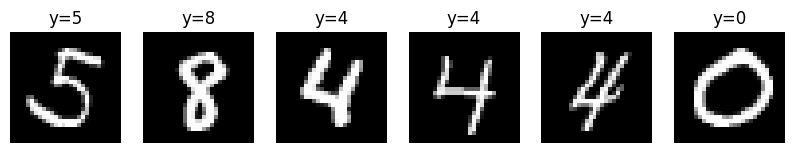

In [3]:
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img = images[i].squeeze().numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"y={labels[i].item()}")
    axes[i].axis("off")
plt.show()

**2. Definir el modelo de red: CNN**
*   Conv() + ReLU + MaxPool
*   Conv() + ReLU + MaxPool
*   Flatten
*   FC() + ReLU
*   FC() (logits)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # -> 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> 32 x 28 -2 +2*0/2 +1 = 32 x 14 x 14

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2)                              # -> 64 x 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # logits
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


**3. Funciones de entrenamiento/evaluación**

In [5]:
def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()


def run_epoch(model, loader, criterion, optimizer=None):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()

    total_loss = 0.0
    total_acc  = 0.0
    n_batches  = 0

    with torch.set_grad_enabled(train_mode):
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)                # logits (sin softmax)
            loss = criterion(logits, y)      # CrossEntropyLoss espera logits

            if train_mode:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            total_acc  += accuracy_from_logits(logits, y)
            n_batches  += 1

    return total_loss / n_batches, total_acc / n_batches

**4. Entrenamiento**

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 2
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc     = run_epoch(model, val_loader,   criterion)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")


Epoch 01 | train loss 0.0370 acc 0.9885 | val loss 0.0496 acc 0.9855
Epoch 02 | train loss 0.0245 acc 0.9922 | val loss 0.0453 acc 0.9869


**Curvas (loss y accuracy)**

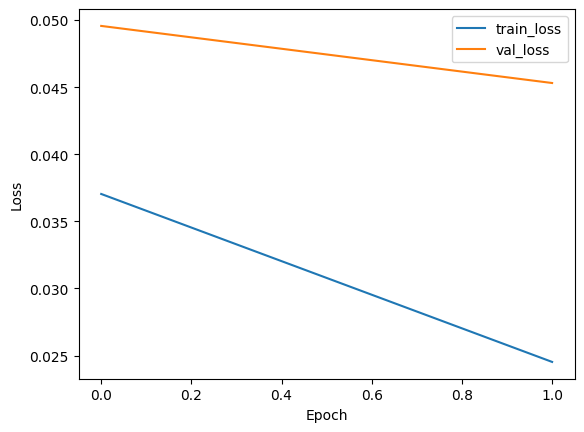

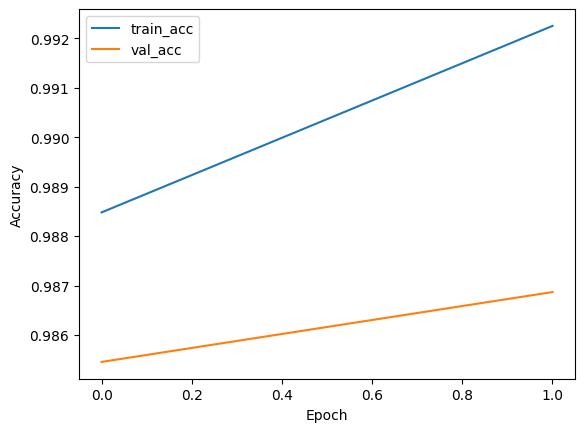

In [8]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**5. Evaluación en test**

In [9]:
test_loss, test_acc = run_epoch(model, test_loader, criterion)
print("Test loss:", test_loss)
print("Test acc :", test_acc)

Test loss: 0.03839461445747886
Test acc : 0.9871616242038217


**6. Predicciones y visualización (aciertos/errores)**


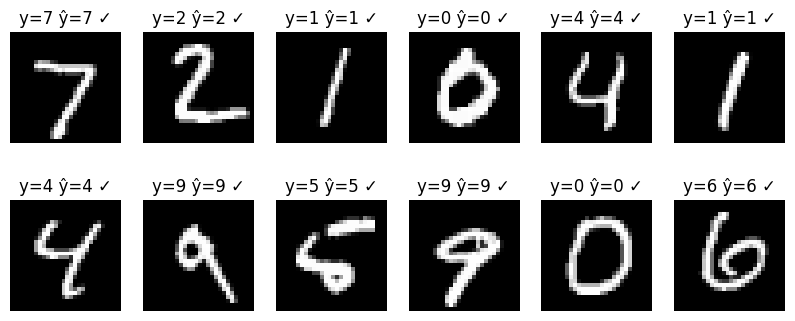

In [10]:
model.eval()
x, y = next(iter(test_loader))
x, y = x.to(device), y.to(device)

with torch.no_grad():
    logits = model(x)
preds = logits.argmax(dim=1)

# Mostrar 12 ejemplos
fig, axes = plt.subplots(2, 6, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(x[i].cpu().squeeze().numpy(), cmap="gray")
    ok = "✓" if preds[i].item() == y[i].item() else "✗"
    ax.set_title(f"y={y[i].item()} ŷ={preds[i].item()} {ok}")
    ax.axis("off")
plt.show()